---
title: Replication Study
author: Otis Milliken
date: '2024-03-3'
description: "Blog Post for CS0451"
format: html
---

# Abstract 


In this blog post, I followed along with the study by Obermeyer, Ziad, Brian Powers, Christine Vogeli, and Sendhil Mullainathan (2019) called “Dissecting Racial Bias in an Algorithm Used to Manage the Health of Populations.” This blog posts steps through their methodology to understand how they got to the conclusions that they did. I found that there existed a black and white patient divide in the correlation between the mean number of chronic illness and risk percentile. However, I didn't find that figure 3 shows a significant different as between black and white patients as people with over 5 chronic illnesses blurs teh picture. I also found that there existed a disportionate cost of black patients compared to white patients.

In [103]:
import pandas as pd
url = "https://gitlab.com/labsysmed/dissecting-bias/-/raw/master/data/data_new.csv?inline=false"
df = pd.read_csv(url)
df["risk_percentile"] = (df["risk_score_t"].rank(pct=True) * 100).round()


## Figure 1

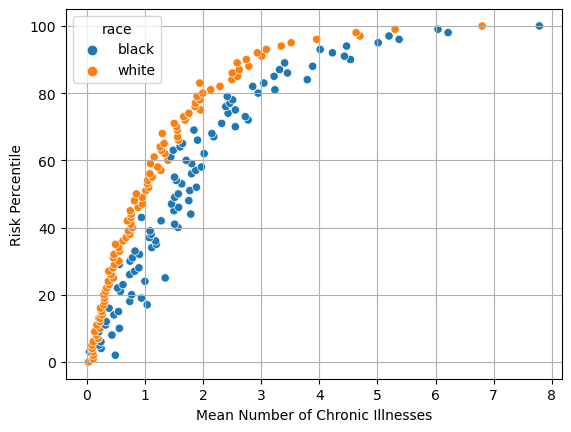

In [104]:
from matplotlib import pyplot as plt
import seaborn as sns

chart = df.groupby(["risk_percentile", "race"]).aggregate({"gagne_sum_t" : "mean"}).reset_index()

sns.scatterplot(data=chart, x="gagne_sum_t", y="risk_percentile", hue="race")
plt.xlabel("Mean Number of Chronic Illnesses")
plt.ylabel("Risk Percentile")
plt.grid(True)

## Explaining Fig 1
The chart shows the White patients on average have to have less chronic illnesses to have higher risk. This means that white patients are more likely to be referred to treatment (high risk treatment) than black patients. For example, a white patient with a risk percentile of 60 needs on average around 1.1 chronic illnesses while a black patient would need to have around 1.8-1.9 chronic illness to be in that same risk percentile.


## Figure 3

[Text(0.5, 0, 'Number of Chronic Of Illnesses'),
 Text(0, 0.5, 'Medical Cost'),
 None]

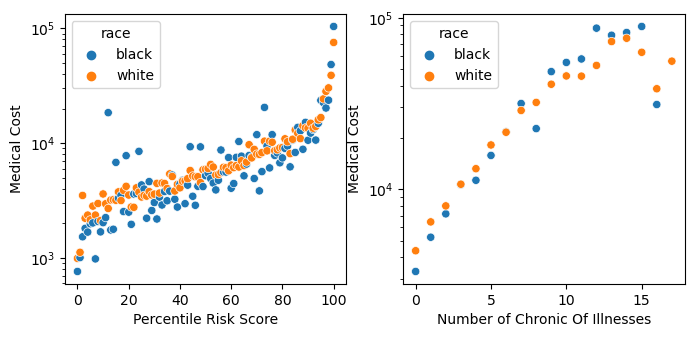

In [105]:
chart2 = df.groupby(["risk_percentile", "race"]).aggregate({"cost_t" : "mean"}).reset_index()
fig, ax = plt.subplots(1, 2, figsize = (8, 3.5))

sns.scatterplot(data=chart2, x="risk_percentile", y="cost_t", hue="race", ax=ax[0])
ax[0].set(xlabel ="Percentile Risk Score", ylabel = "Medical Cost", yscale="log")

chart3 = df.groupby(["race", "gagne_sum_t"]).aggregate({"cost_t" : "mean"}).reset_index()

sns.scatterplot(data=chart3, x="gagne_sum_t", y="cost_t", hue="race", ax=ax[1])
ax[1].set(xlabel ="Number of Chronic Of Illnesses", ylabel = "Medical Cost", yscale="log")


### Explaining Figure 3
The paper argues that there is little difference in cost based on percentile risk shown in Figure 1 but that black patients tend to have lower costs for the number of chronic illnesses they have. I'm not sure the tables I created totally supports that hypothesis as both seem to have small differences between them. For example, between 7 and 14 chronic illnesses, it looks like black patients actually cost more than white patients. This could be because there's not very many patients with over 5 chronic illnesses.

## Splitting Data

You might have noticed that there isn't much data about patients with 5 or less chronic illnesses. Therefore, we are going to limit the dataset to only patients with 5 or less chronic illnesses to prevent outliers.

In [106]:
fiveOrLess = df[df["gagne_sum_t"] < 5]

percentage = len(fiveOrLess)/len(df) * 100
print("Percentage of patients with 5 or less chronic illnesses: ", round(percentage, 2), "%")

Percentage of patients with 5 or less chronic illnesses:  93.0 %


Here we calculate the log cost. This is important because our target variable varies widely across several orders of magnitude.

In [107]:
fiveOrLess = fiveOrLess[fiveOrLess["cost_t"] > 0]
fiveOrLess["log_cost"] = fiveOrLess["cost_t"].transform("log")

In this step, we create a dummy column that has 0 meaning that the parient is white and 1 meaning that the patient is black. I also found that only 10% of the patients in this study were black. This is however not terribly lower than the U.S population average of 13%.

In [108]:
fiveOrLess["race_dummy"] = 1 * (fiveOrLess["race"] == "black")
fiveOrLess["race_dummy"].mean()

0.10478072089871121

In [109]:
X_train = fiveOrLess[["race_dummy", "gagne_sum_t"]]
y_train = fiveOrLess["log_cost"]

## Polynomial Features

Since we are trying to fit a non-linear function with a linear regression, we can add polynomial features to improve our model. For example, in the following code block, I add polynomials of gagne_sum_t up to 8 degrees and print out the cross valuation score. I then pick the degree with the best score to use for my model.

In [110]:
def add_polynomial_features(X, degree):
  X_ = X.copy()
  for j in range(1, degree):
    X_[f"poly_{j}"] = X_["gagne_sum_t"]**j
  return X_

In [115]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score

for degree in range(1, 6):
    LR = LinearRegression()
    X_polyTrain = add_polynomial_features(X_train, degree)
    LR.fit(X_polyTrain, y_train)
    cv_score_LR = cross_val_score(LR, X_polyTrain, y_train, cv=5)
    print(f"Degree {degree}: {cv_score_LR.mean()}")


Degree 1: 0.0707003471161072
Degree 2: 0.07069112920880076
Degree 3: 0.07180211781434358
Degree 4: 0.07245274257563275
Degree 5: 0.07313225738549074


## Selecting Degree

As we can see, degree 5 has the best score so we will select that to train our model which I do in the next step. It also makes sense with the fact that at over 5 conditions, our data becomes more sparse.

In [112]:
FinalLR = LinearRegression()
X_trainFinal = add_polynomial_features(X_train, 5)
FinalLR.fit(X_trainFinal, y_train)


LinearRegression()

In [113]:
print(X_trainFinal.columns)
print(FinalLR.coef_)


Index(['race_dummy', 'gagne_sum_t', 'poly_1', 'poly_2', 'poly_3', 'poly_4'], dtype='object')
[-2.87073428e-01 -1.02948142e+11  1.02948142e+11 -7.32982800e-01
  2.72133230e-01 -3.23777558e-02]


## Getting cost

We can now calculate the cost incurred by black patients. We calculate that in the next code block by finding the coefficient that corresponds with race.

In [114]:
import numpy as np
np.exp(LR.coef_[0])

0.7504566226125335

Here we see that the percentage cost of black patients is unsually high at around 76.6%. 

### Discussion 
As mentioned in the abstract, this paper found that there existed a black and white patient divide in the correlation between the mean number of chronic illness and risk percentile. It found that there existed a disportionate cost of black patients compared to white patients with 76.6%. Essentially that when black patients have similar levels of chronic illness at white patients, they are still recieving lower scores than their counterparts. This means that less black patients are not recieving the care that they need since they overall have lower scores. These results are in line with those that Obermeyer et al. (2019) found in their paper. This exercises showcases how past historical data, like how black patients tend to recieve less care, can creep into algorithmic decision making.

Of the three types of algorithmic bias guidelines: error rate parity, acceptance rate parity, and sufficiency, the study by Obermeyer et al. (2019) most clearly looks at error rate parity. This is because when we examine risk percentile scores to medical costs, we don't see much of a difference between races. However, when we examine who gets what risk percentile scores, we see that white patients are often possibly higher scores than they are supposed to while black patients are given lower scores. Obermeyer points out that the algorithm falsely concludes that "black patients are healthier than equally sick white patients".